In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.integrate import cumtrapz
import sys, os, string
from scipy.signal import savgol_filter
import scipy.io as sio
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from autophasemap import SquareRootSlopeFramework

color_blindf = ["#3f90da", "#ffa90e", "#bd1f01", "#832db6", 
"#a96b59", "#e76300", "#b9ac70", "#92dadd", "#94a4a2"]
bkg_spectra_color = "#717581"
SAVE_DIR = "../../figures/FeGaPd/"

In [3]:
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight'
              } 

In [4]:
FGP = sio.loadmat('../../expts/FeGaPd/FeGaPd_full_data_200817a.mat')

C = FGP['C'] # composition
XRD = FGP['X'][:,631:1181] # X-ray diffraction intensities
T = FGP['T'][:,631:1181].squeeze() # 2theta for the XRD intensities
N, n_domain = XRD.shape

n_clusters=5

In [5]:
class DataSet:
    def __init__(self, C, q, Iq, N, n_domain=200):
        self.n_domain = n_domain
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = N
        self.Iq = Iq
        self.C = C
        self.q = q
        
    def generate(self, normalize=True):
        if normalize:
            self.F = [self._smoothen(self.Iq[i,:])/self.l2norm(self.Iq[i]) for i in range(N)]
        else:
            self.F = [self.Iq[i,:] for i in range(N)]
            
        return
    
    def _smoothen(self, f):
        f_hat = savgol_filter(f, 51, 3)
        
        return f_hat
    
    def l2norm(self, f):
        norm = np.sqrt(np.trapz(f**2, data.t))
        
        return norm

data = DataSet(C, T, XRD, N, n_domain=n_domain)
data.generate(normalize=True)
print('Total number of samples %d'%data.N)

Total number of samples 278


In [6]:
# load results from Hyak run
with open('./data.pkl', 'rb') as handle:
    result = pickle.load(handle)

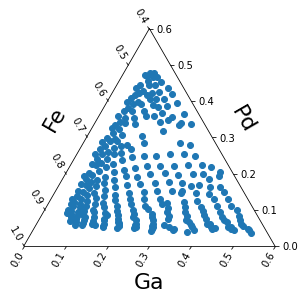

In [8]:
def make_ternary(ax):
    ax.set_ternary_min(0.0, 0.4, 0.0)
    ax.set_ternary_max(0.6, 1.0, 0.6)
    ax.set_tlabel('Pd', fontsize=22)
    ax.set_llabel('Fe', fontsize=22)
    ax.set_rlabel('Ga', fontsize=22)

    ax.taxis.set_ticks_position('tick1')
    ax.laxis.set_ticks_position('tick1')
    ax.raxis.set_ticks_position('tick1')

    ax.taxis.set_label_position('tick1')
    ax.laxis.set_label_position('tick1')
    ax.raxis.set_label_position('tick1')

    return ax

import mpltern

fig, ax = plt.subplots(subplot_kw = {'projection' : "ternary"})
Fe, Pd, Ga = C[:,0], C[:,1], C[:,2]
ax.scatter(Pd, Fe, Ga)
make_ternary(ax)
plt.show()

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1637/774884210.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('magma')


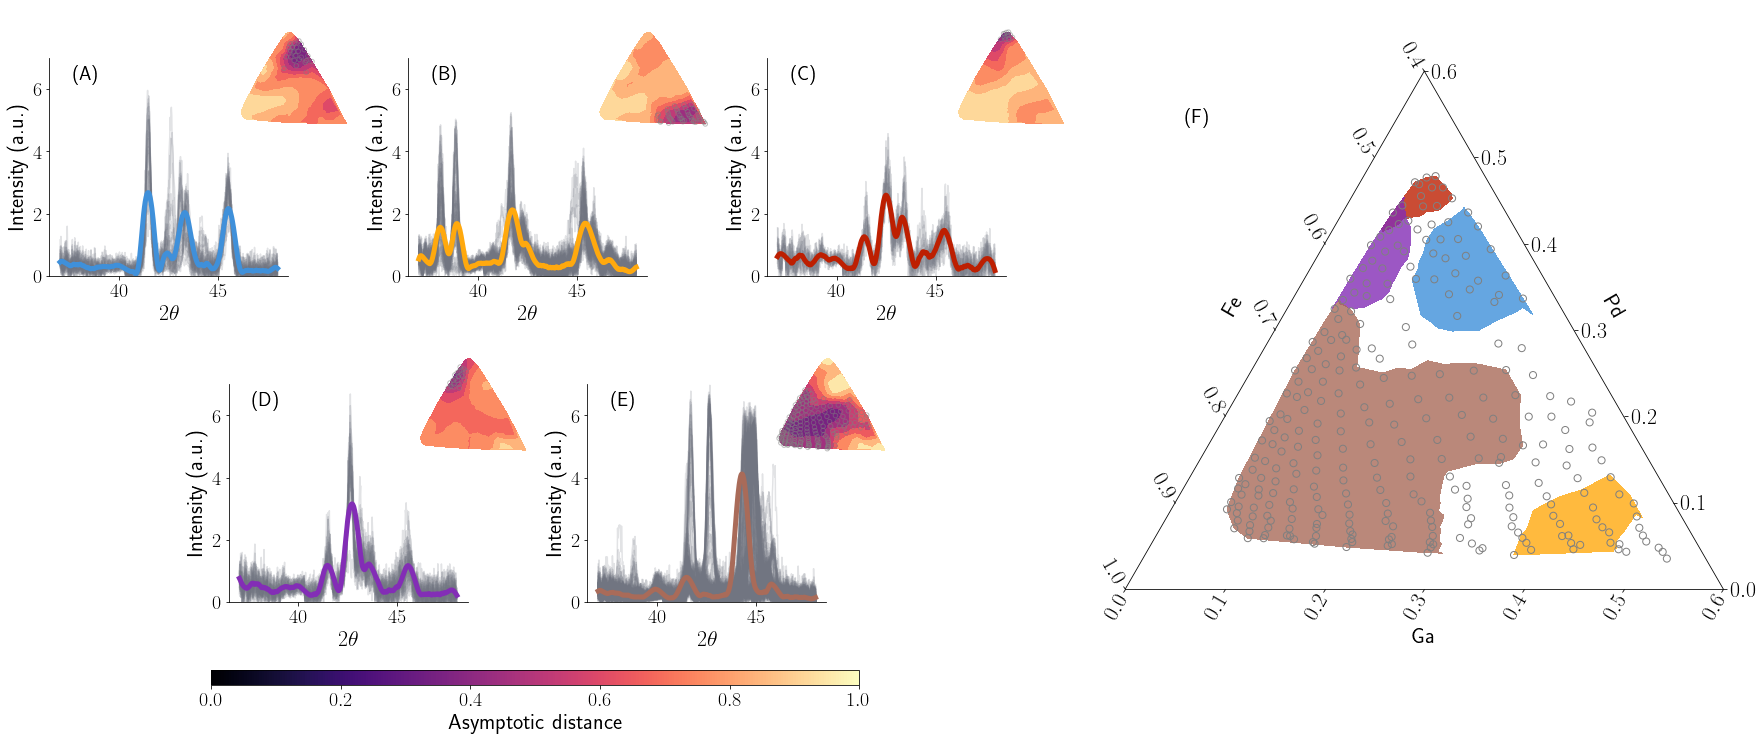

In [10]:
cmap = cm.get_cmap('magma')
norm = Normalize(vmin=0, vmax = 1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)

def setup_axs():
    layout = [['A', 'A', 'B', 'B', 'C', 'C', 'F', 'F', 'F', 'F'],
              ['.', 'D', 'D', 'E', 'E', '.', 'F', 'F', 'F', 'F']
              ]
    fig, axs = plt.subplot_mosaic(layout, figsize=(5*6, 5*2), 
                                  per_subplot_kw={"F":{'projection':"ternary"}}
                                  )
    fig.subplots_adjust(wspace=3.0, hspace=0.5)
    for k,ax in axs.items():
        ax.text(0.1, 0.9, r'(%s)'%k, 
        transform=ax.transAxes, 
        size=20, weight='bold'
        )
    return fig, axs

def plot_clusters(axs, data, result, use_aligned=True):
    """ Plot phase map and corresponding spectra.

        axs  : axis handles
        data : DatSet object
        out  : Output from the cluster run

        use_aligned : Whether to plot aligned spectra
    """
    labels = result['delta_n']
    n_templates = len(np.unique(labels))
    SRSF = SquareRootSlopeFramework(data.t)

    for k in range(n_templates):
        Mk = np.argwhere(labels==k).squeeze()
        for cs in Mk:
            Iq_query = data.Iq[cs,:]
            Iq_normalized = Iq_query/data.l2norm(Iq_query)
            if use_aligned:
                gamma = result['gam_ik'][cs, k,...]
                spectra = SRSF.warp_f_gamma(Iq_normalized, gamma)
            else:
                spectra = Iq_normalized
                
            axs[k].plot(data.q, spectra, 
                        color=bkg_spectra_color,
                        alpha = 0.2
                       )
            axs[k].set_ylim([0.0, 7.0])
            axs[k].set_xlabel(r'$2\theta$', fontsize=22)
            axs[k].set_ylabel(r'Intensity (a.u.)', fontsize=22)
            axs[k].tick_params(labelsize=20)
    
        axs[k].plot(data.q, result['templates'][k], color=color_blindf[k], lw=5.0)
        
        axins = axs[k].inset_axes([0.7, 0.65, 0.6, 0.6], projection='ternary')
        axins.tricontourf(Pd, Fe, Ga, result['dist'][:,k], 
                     cmap=cmap,norm = norm
                     )
        axins.scatter(Pd[result['delta_n']==k], 
                      Fe[result['delta_n']==k],
                      Ga[result['delta_n']==k],
                      facecolors='none', edgecolors='grey',s=20, alpha=0.5
                      )
        make_ternary(axins)
              
        axins.axis('off')
        
    ax = axs[-1]
    for k in range(n_clusters):
        ax.tricontourf(Pd, Fe, Ga,result['dist'][:,k],
        levels=[0.0, 0.5],
        colors=color_blindf[k],
        alpha=0.8
        )
    ax.scatter(Pd,Fe,Ga,
               facecolors='none', edgecolors='grey',s=50
               )
    make_ternary(ax)   
    cax = fig.add_axes([0.2, 0.01, 0.3, 0.02])        
    cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_xlabel('Asymptotic distance',
                    labelpad=5,
                    fontsize=22,
                    rotation='horizontal'
                    ) 
        
    return

with plt.style.context(pyplot_style):   
    fig, axs = setup_axs()
    ax_clusters = [axs[k] for k in ['A', 'B', 'C', 'D', 'E', 'F']]
    fig.subplots_adjust(wspace=2.0, hspace=0.5)
    plot_clusters(ax_clusters, data, result, use_aligned=False)
    plt.savefig(SAVE_DIR+'templates_5.pdf')